# Introduction

This project is based on the [PhysioNet/Cardiology (CinC) Challenge 2017](https://physionet.org/content/challenge-2017/1.0.0/) and a Udacity course. The CINC challenge aimed to encourage the development of algorithms to classify, whether short single lead ECG recordings (between 30 s and 60 s in length) show normal sinus rhythm, atrial fibrillation (AF), an alternative rhythm, or is too noisy to be classified. The challenge data uses ECG recordings, collected using the AliveCor device, which were generously donated for this Challenge by AliveCor.



This training set contains single lead ECG recordings lasting from 9 s to just over 60 s. The recordings were sampled at 300 Hz and have been band pass filtered by the AliveCor device. Figure 1 shows the examples of the ECG waveforms (lasting for 20 s) for the four classes in this Challenge. From top to bottom, they are ECG waveforms of normal rhythm, AF rhythm, other rhythm and noisy recordings.

![Figure 1. Example of the ECG waveforms](figures/example_waveforms.svg)

In this project, we will start by building a simpler two-class classifier distinguishing between normal sinus rhythm and abnormal rhythms (atrial fibrillation included) by excluding the noisy recordings. We will thus use 7,418 out of the original 8,528 training data recordings. They have been converted into 'npz' format from the original MATLAB V4 WFDB-compliant format. 

We will perform the following 
1. Even though, RR intervals are already provided, we will first build an algorithm to extract RR intervals using the Pan-Tompkins method and measure the accuracy performance of our algorithm.
2. We will then process and extract features from the RR intervals data for our classifier.
3. Build and compute the performance of a 2-class random forest classifier
4. Build and compute the performance of a 3-class random forest classifier (between Normal, Other and Afib rhythms)

We then perform additional analyses to help improve the accuracy of the classifier  
1. Adding more features requiring additional processing and features extraction from the raw signal
2. Performing a grid search for hyperparameter tuning
3. Comparing performance comparison among 8 common classifiers which includes hyperparameter tunning for each


We will eventually take the challenge of 
1. Performing a grid search for hyperparameter tuning
2. Comparing different classifiers
2. Distinguishing between AF from alternative rhythm. This most likely will require extracting features other than RR intervals data, such as the presence/absence of P-wave (see Figure 2).

![Figure 2. Depiction of the QRS complex during the cardiac cycle (figure was obtained from https://en.wikipedia.org/wiki/Wiggers_diagram) ](figures/Wiggers_Diagram.png)





# Data Exploration

## Imports

In [16]:
import glob
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import scipy.signal

np.warnings.filterwarnings('ignore')

## Load Raw ECG Data + QRS locations

The data is stored in `npz` files. We are given both the raw ECG data as well as the QRS complex locations.
We will also load cardiac rhythm labels even though this will only be used later for our classification algorithm.

In [17]:
fs = 300
data_dir = 'data/'
# ref = pd.read_csv(data_dir + 'REFERENCE.csv')
#ref = dict(zip(ref.record, ref.rhythm))
ref = pd.read_csv(data_dir + 'REFERENCE_original.csv')

# create a vector with 2 classes by changing A to O 
# note that there is a fourth class "~", but those records are not in the "data" folder
rhythm2 = np.array(ref.rhythm)
rhythm2[ref.rhythm == 'A']='O'
ref_dict = dict(zip(ref.record, ref.rhythm))
ref2_dict = dict(zip(ref.record, rhythm2))

base = lambda f: os.path.splitext(os.path.basename(f))[0]
files = sorted(glob.glob(data_dir + '*.npz'))
SID, ecgs, qrs, labels2, labels = [], [], [], [], []
for f in files:
    with np.load(f) as npz:
        ecgs.append(npz['ecg'])
        qrs.append(npz['qrs'])
    labels.append(ref_dict[base(f)])
    labels2.append(ref2_dict[base(f)])
    SID.append(base(f))

print(pd.DataFrame(zip(SID, labels2, labels),columns=['SubjectID','2 Class Label','3 Class Label']))

     SubjectID 2 Class Label 3 Class Label
0       A00001             N             N
1       A00002             N             N
2       A00003             N             N
3       A00004             O             A
4       A00005             O             A
...        ...           ...           ...
7411    A08524             N             N
7412    A08525             O             O
7413    A08526             N             N
7414    A08527             N             N
7415    A08528             N             N

[7416 rows x 3 columns]


# Process and Extract RR data using the Pan-Tompkins Algorithm

Even though the QRS locations are given to us along with the ECG raw signal, we will be implementing the Pan-Tompkins Algorithm to compute those QRS complex locations on our own. We will then assess the performance of our algorithms by comparing the precision/recall accuracy against the QRS locations provided (within a 40ms toloerance window) 

## Pan-Tompkins Algorithm

The Pan-Tompkins algorithm is a series of pre-processing steps to amplify the QRS complex amplitude and a detection algorithm for finding these complexes. 

1. bandpass filtering between 5-15Hz to remove low and high freq content
2. Moving sum, first derivative (diff) and square to enhance the peaks
3. Find peaks
4. Remove non physiological peaks by
    - removing peaks within 200ms of prior one due to refractory period
    - adaptive treshold keeping peak 30% [compared to suggested 70%] above prior 8 peaks average
    - remove T-wave by making sure that slope of following peak within 360ms is greater than half the prior one (T-wave are not as sharp)


In [18]:
def BandpassFilter(signal, fs=300):
    """Bandpass filter the signal between 5 and 15 Hz."""
    b, a = sp.signal.butter(3, (5, 15), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def MovingSum(signal, fs=300):
    """Moving sum operation with window size of 150ms."""
    n_samples = int(round(fs * 0.150))
    return pd.Series(signal).rolling(n_samples, center=True).sum().values

def FindPeaks(signal, order=10):
    """A simple peak detection algorithm."""
    # Didier: local maxima of neighboring 10 prior/later point)
    # Didier: find datapoints greater than order=10th earlier and later datapoints
    msk = (signal[order:-order] >= signal[:-order * 2]) & (signal[order:-order] >= signal[order * 2:])
    # Didier: then make sure that this point is greater the all surrounding  
    # order=10 prior and later points     
    for o in range(1, order):
        msk &= (signal[order:-order] >= signal[o: -order * 2 + o])
        msk &= (signal[order:-order] >= signal[order * 2 - o: -o])
    return msk.nonzero()[0] + order

def ThresholdPeaks(filtered_signal, peaks):
    """Threshold detected peaks to select the QRS complexes."""
    thresh = np.mean(filtered_signal[peaks])
    return peaks[filtered_signal[peaks] > thresh]

def AdaptiveThresholdPeaks(filtered_signal, peaks):
    # Make the detection threshold 70% of the average peak height for the last 8 peaks
    order = 8
    thresh_perc = 0.3 # was 0.7
    shift = 'No' # set to 'centered' for centered mean average
    # build threshold vector data for each QRS complex/peaks that will be compared to 
    # This is achieving by computing a moving average using cumsum
    MApeak = np.cumsum(np.concatenate((np.zeros(order),filtered_signal[peaks]))) 
    # add -Inf as first element is compared to nothing
    if shift == 'centered':
        # trying to have a centered mean but need more working; to not be used at this point
        MApeak = np.cumsum(np.concatenate((np.zeros(order),filtered_signal[peaks],np.zeros(order-1))))
        MApeak = np.concatenate(((float('-inf'),),MApeak[order:] - MApeak[:-order]
                      ,(filtered_signal[-1],)))[shift+1:len(MApeak)-int(order/2)]
    else:
        MApeak = np.concatenate(((float('-inf'),),MApeak[order:] - MApeak[:-order]))[:-1]
  
    # Then build weight vector for computing average (first order=8 samples are compared to
    # the increasing number of prior samples from 1:order )
    # Used min to take care of situation where order>len(peaks)
    Weight = np.concatenate(((1,),np.arange(1,np.min((order+1,len(peaks))),1),
                             np.ones(np.max((0,len(peaks)-order-1)))*order))
    # divide MApeak vector by weight vector 
    MApeak = np.divide(MApeak,Weight)
    # Perform the comparison and keep peaks > thresh_perc * MApeak
    peaks_new = peaks[filtered_signal[peaks] > thresh_perc * MApeak ]
    
    # plt.figure()
    # ts = np.arange(len(filtered_signal))/300
    # plt.plot(ts,filtered_signal,'b')
    # plt.plot(ts[peaks],filtered_signal[peaks],'.k',ms=7)
    # plt.plot(ts[peaks_new],filtered_signal[peaks_new],'.r',ms=7)
    # plt.title('Adaptive Threshold Peaks')
    # plt.show()
    # plt.waitforbuttonpress()

    return peaks_new
    # Didier: This is the solution provided. However this is not doing the right thing!
    # It compares each peak to the prior 8th one (rather than mean average of prior 8 peaks) 
    return peaks[filtered_signal[peaks] > thresh_perc * 
                 np.concatenate((np.ones(8)*float("-inf") , filtered_signal[peaks[:-order]])) ]

    
def RefractoryPeriodBlanking(filtered_signal, peaks, fs, refractory_period_ms=200):
    #select all peaks within refractory_period_ms
    peaks_new = peaks
    # idx_refrac = np.where(np.diff(peaks_new) < refractory_period_ms/1000*fs)[0]
    # idx_refrac = np.unique(np.concatenate((idx_refrac,idx_refrac+1)))
    idx_refrac =0
    
    # plt.figure()
    # ts = np.arange(len(filtered_signal))/fs
    # plt.plot(ts,filtered_signal,'b')
    # plt.plot(ts[peaks_new],filtered_signal[peaks_new],'.k',ms=7)
    # ref_line = plt.plot(ts[peaks_new],filtered_signal[peaks_new],'.r',ms=7)
    # plt.title('Refractory Period Blanking')
    # plt.show()
    
    while idx_refrac  != []:
        # find and delete smallest peaks in all refractory regions  
        # find indices of all peaks within a refractory_period_ms distance of another
        idx_refrac = np.where(np.diff(peaks_new) < refractory_period_ms/1000*fs)[0]
        idx_refrac = np.unique(np.concatenate((idx_refrac,idx_refrac+1)))
        # delete the smallest peak and continue until no more peaks in refractory regions
        if idx_refrac  != []:
            idx_del = idx_refrac[np.argmin(filtered_signal[peaks_new[idx_refrac]])]
            peaks_new = np.delete(peaks_new,idx_del)

        # line = ref_line.pop(0)
        # line.remove()
        # ref_line = plt.plot(ts[peaks_new],filtered_signal[peaks_new],'.r',ms=7)
        # plt.show()
        # plt.waitforbuttonpress()
    
    # plt.clf    
    # plt.plot(ts,filtered_signal,'b')
    # plt.plot(ts[peaks],filtered_signal[peaks],'.k',ms=7)
    # plt.plot(ts[peaks_new],filtered_signal[peaks_new],'.r',ms=7)
    # plt.title('Refractory Period Blanking')
    # plt.show() 
    # plt.waitforbuttonpress()       
    
    return peaks_new

def TWaveDiscrimination(signal, peaks, fs, twave_window_ms=360, slope_window_ms=60):
    # Find peaks that follow a previous one by 360ms or less
    peaks_new = peaks
    slope_window = int(slope_window_ms/1000*fs)
    for tmp,idx in enumerate(np.where(np.diff(peaks) < twave_window_ms/1000*fs)[0]):
    # same as 
    # for i, idx in enumerate(j for j in range(len(peaks)-1) if (np.diff(peaks)[j] < twave_window_ms/1000*fs))
        max_slope1 = np.max(np.abs(np.diff(signal[peaks[idx] - slope_window:
                                                 peaks[idx] + slope_window])))
        max_slope2 = np.max(np.abs(np.diff(signal[peaks[idx+1] - slope_window:
                                                     peaks[idx+1] + slope_window])))
        if max_slope2   < 0.5* max_slope1:
            np.delete(peaks_new,idx+1)
            
    # plt.figure()
    # ts = np.arange(len(signal))/fs
    # plt.plot(ts,signal,'b')
    # plt.plot(ts[peaks],signal[peaks],'.k',ms=7)
    # plt.plot(ts[peaks_new],signal[peaks_new],'.r',ms=7)
    # plt.title('Twave Discrimination')
    # plt.show()  
    # plt.waitforbuttonpress()    
            
    return peaks_new
                  
def PanTompkinsPeaks(signal, fs):
    """Pan-Tompkins QRS complex detection algorithm."""
    filtered_signal = MovingSum(
        np.square(
            np.diff(
                BandpassFilter(signal, fs))), fs)
    peaks = FindPeaks(filtered_signal)
    peaks = RefractoryPeriodBlanking(filtered_signal, peaks, fs)  # TODO: Uncomment this line
    #peaks = ThresholdPeaks(filtered_signal, peaks)                 # TODO: Remove this line
    peaks = AdaptiveThresholdPeaks(filtered_signal, peaks)        # TODO: Uncomment this line
    peaks = TWaveDiscrimination(signal, peaks, fs)                # TODO: Uncomment this line
    return peaks


## Performance Evaluation Helpers

Let's first build a function that tells us the performance of our QRS estimates.

In [19]:
def Evaluate(reference_peak_indices, estimate_peak_indices, tolerance_samples=40):
    """Evaluates algorithm performance for a single dataset.
    
    It is not expected that reference and estimate peak indices overlap exactly.
    Instead say a QRS estimate is correct if it is within <tolerance_samples> of
    a reference estimate.
    
    Args:
        reference_peak_indices: (np.array) ground-truth array of QRS complex locations
        estiamte_peak_indices: (np.array) array of QRS complex estimates
        tolerance_samples: (number) How close a QRS estimate needs to be to a reference
            location to be correct.
    Returns:
        n_correct: (number) The number of QRS complexes that were correctly detected
        n_missed: (number) The number of QRS complexes that the algorithm failed
            to detect
        n_extra: (number) The number of spurious QRS complexes detected by the
            algorithm
    """
    # Keep track of the number of QRS peaks that were found correctly
    n_correct = 0
    # ... that were missed
    n_missed = 0
    # ... and that are spurious
    n_extra = 0
    
    # Loop counters
    i, j = 0, 0
    while (i < len(reference_peak_indices)) and (j < len(estimate_peak_indices)):
        # Iterate through the arrays of QRS peaks, counting the number of peaks
        # that are correct, missed, and extra.
        ref = reference_peak_indices[i]
        est = estimate_peak_indices[j]
        if abs(ref - est) < tolerance_samples:
            # If the reference peak and the estimate peak are within <tolerance_samples>,
            # then we mark this beat correctly detected and move on to the next one.
            n_correct += 1
            i += 1
            j += 1
            continue
        if ref < est:
            # Else, if they are farther apart and the reference is before the estimate,
            # then the detector missed a beat and we advance the reference array.
            n_missed += 1
            i += 1
            continue
        # Else, the estimate is before the reference. This means we found an extra beat
        # in the estimate array. We advance the estimate array to check the next beat.
        j += 1
        n_extra += 1
    # Don't forget to count the number of missed or extra peaks at the end of the array.
    n_missed += len(reference_peak_indices[i:])
    n_extra += len(estimate_peak_indices[j:])
    return n_correct, n_missed, n_extra

Now we need a function that can compute precision and recall for us.

In [20]:
def PrecisionRecall(n_correct, n_missed, n_extra):
    # TODO: Compute precision and recall from the input arguments.
    precision = n_correct/(n_correct + n_extra) # true positive / (true positive+false positive) -> do not want diagnose extra 
    recall = n_correct/(n_correct + n_missed)  # true positive / (true positive + false negative) -> do not want to miss  
    return precision, recall

## Evaluate Performance 

Using the PrecisionRecall function above, we will compute an overall precision and recall for QRS detection. 

In [21]:
%matplotlib auto

Using matplotlib backend: QtAgg


In [22]:
# Keep track of the total number of correct, missed, and extra detections.
total_correct, total_missed, total_extra = 0, 0, 0

for i, fl in enumerate(files):
    # For each file, load the data...
    
    ecg = ecgs[i]
    reference_peak_indices = qrs[i]
    
    #with np.load(fl) as npz:
    #    ecg = npz['ecg']
    #    reference_peak_indices = npz['qrs']
    # Compute our QRS location estimates...
    estimate_peak_indices = PanTompkinsPeaks(ecg, fs)

    # Compare our estimates against the reference...
    n_correct, n_missed, n_extra = Evaluate(reference_peak_indices, estimate_peak_indices)

    # Uncomment if you want to visually compare ECG peak detection with ECG ref
    # plt.clf()
    # ts = np.arange(len(ecg))/fs 
    # plt.plot(ts,ecg,'b')
    # plt.plot(ts[estimate_peak_indices],ecg[estimate_peak_indices],'r.',ms=5)
    # plt.plot(ts[reference_peak_indices],ecg[reference_peak_indices],'k+',ms=5)
    # plt.title(fl[-10:-4] + '(missed:' + str(n_missed) + ',extra:' + str(n_extra) + ")" )
    # plt.show()
    # plt.pause(1)
    # plt.waitforbuttonpress()
    
    # And add them to our running totals.
    total_correct += n_correct
    total_missed += n_missed
    total_extra += n_extra
    print('\r{}/{} files processed...'.format(i+1, len(files)), end='')
print('') # print a newline

# Compute and report the overall performance.
precision, recall = PrecisionRecall(total_correct, total_missed, total_extra)
print('Total performance:\n\tPrecision = {:0.2f}\n\tRecall = {:0.2f}'.format(precision, recall))

7416/7416 files processed...
Total performance:
	Precision = 0.93
	Recall = 0.99


The performance of our algorithm is reasonable with a 93% precision and 99% recall, i.e. the ability to correctly detect 93% of the peaks with 1% of them being wrongly labelled as a QRS peak (false positive) 

In [23]:
%matplotlib inline

# AF classifier

In this section, we will be create a Random Forest Classifier to classify normal from abnormal ECG rhythms. We will first extract features mainly from the RR interval time series, and then compute the performance of the algorithm. 

We will first create a model using a max depth of 4 and 100 trees, before optimizing hyperparameters using a grid search.

## Features

The features for the AF detection algorithm are computed from the RR interval time series. We use the time domain and frequency domain features listed below.

### Time domain
 - minimum RR interval
 - maximum RR interval
 - median RR interval
 - average RR interval
 - standard deviation of RR intervals
 - number of RR interval outliers
   - An RR interval is an outlier if it is greater than 1.2x the average RR interval in the ECG record
 - root-mean-square of the difference between adjacent RR intervals
 - percent of RR interval differences greater than 50 milliseconds

### Frequency domain
The RR interval time series is not sampled regularly in time. We only have a datapoint every heart beat. Before we can compute any frequency domain features, the time series must be resampled so that we get uniform data points. Resample the RR interval time series to 4 Hz before computing the features below.

 - peak magnitude between 0.04 Hz and 0.15 Hz in the regularized RR interval time series
 - main frequency between 0.04 Hz and 0.15 Hz in the regularized RR interval time series
 - peak magnitude between 0.15 Hz and 0.4 Hz in the regularized RR interval time series
 - main frequency between 0.15 Hz and 0.4 Hz in the regularized RR interval time series

In [24]:
def Featurize(qrs_inds, fs):
    """Featurize the qrs complex locations time series.

    Args:
        qrs_inds: (np.array of number) the sample indices of the QRS complex locations
        fs: (number) the sampling rate

    Returns:
        n-tuple of features
    """
    # Compute the RR interval time series in s
    RR = np.diff(qrs_inds)/fs
    
    # Compute time domain features
    min_rr = np.min(RR)
    max_rr = np.max(RR)
    median_rr = np.median(RR)
    mean_rr = np.mean(RR)
    std_rr = np.std(RR)
    n_outliers = np.sum(RR>1.2*mean_rr)
    rmssd = np.sqrt(np.mean(np.square(np.diff(RR))))
    pdrr_50 = 100*np.mean(np.diff(RR)>0.05)

    # Regularly resample the RR interval time series (done in terms of samples)
    fsi = 4 #resampling at 4Hz
    tsi = np.arange(qrs_inds[0]/fs, qrs_inds[-2]/fs, 1/fsi)
    RRi = np.interp(tsi,qrs_inds[:-1]/fs,RR)



    # Compute the Fourier transform of the regular RR interval time series
    freq = np.fft.rfftfreq(len(RRi), 1 / 4)
    fft_mag = np.abs(np.fft.rfft(RRi))

    # Compute frequency domain features
    ############# Didier
    # There was an error in the original solution
    # The size of the data within a certain freq band is smaller than the whole frequency data range
    # As such, the index pointing to the maximum of a freq band should be with respect to that freq band (not the whole range of freq)
    lf_mag = np.max(fft_mag[(freq >= 0.04) & (freq <= 0.15)])
    #lf_freq = freq[np.argmax(fft_mag[(freq >= 0.04) & (freq <= 0.15)])]  #<- error
    lf_freq = freq[(freq >= 0.04) & (freq <= 0.15)][np.argmax(fft_mag[(freq >= 0.04) & (freq <= 0.15)])]
    hf_mag = np.max(fft_mag[(freq >= 0.15) & (freq <= 0.4)])
    #hf_freq = freq[np.argmax(fft_mag[(freq >= 0.15) & (freq <= 0.4)])] #<- error
    hf_freq = freq[(freq >= 0.15) & (freq <= 0.4)][np.argmax(fft_mag[(freq >= 0.15) & (freq <= 0.4)])]


    return (min_rr, max_rr, median_rr, n_outliers, mean_rr, std_rr, rmssd, pdrr_50,
            lf_mag, lf_freq, hf_mag, hf_freq)

## Create Feature Matrix

In trying to run Featurize on our data, curiously record 4682 was found to have not qrs?
Let's first compute them using our algorithm

[]


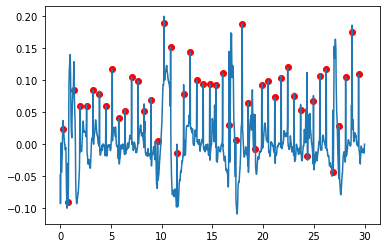

In [25]:
# For some reason record 4682 doesn't have any qrs ???
# Compute it using our algorithm
print(qrs[4682])

qrs[4682] = peaks = PanTompkinsPeaks(ecgs[4682], fs)
ts = np.arange(len(ecgs[4682]))/fs
plt.plot(ts,ecgs[4682]);
plt.scatter(ts[peaks],ecgs[4682][peaks],color='r');

In [26]:
feats = [Featurize(qrs_inds, fs) for qrs_inds in qrs]      
X, y, y2 = np.array(feats), np.array(labels), np.array(labels2)
print(X.shape)

(7416, 12)


## Build a Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, cross_val_predict, StratifiedKFold



### A Random Forest Model for 2 Classes  ('Other' and 'Normal')

Accuracy from fitting the entire dataset=0.813, Accuracy from CV=0.807 (0.015)
Precision CV=0.800 (0.016), Recall CV=0.808 (0.013)


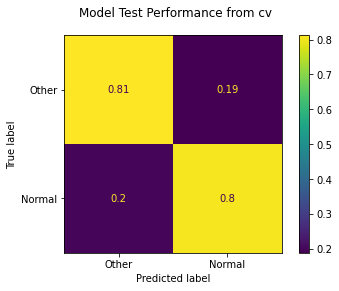

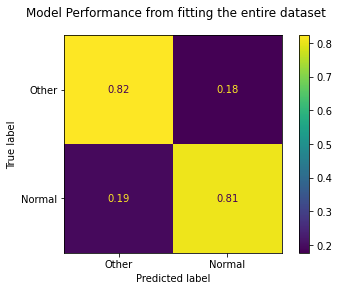

In [28]:
# Let's start with a random forest with 100 trees and a depth of 4.
# The performance of the classifier is evaluated using a K-Fold cross validation stratified by classes.
class2_names = np.array(['O','N'])
class2_names_str = np.array(['Other','Normal'])

# building the k-fold stratified splits
skf = StratifiedKFold(n_splits=5)
## Building the model
clf = RandomForestClassifier(n_estimators=100, max_depth=4, 
                               random_state=42, class_weight='balanced')
# Define scoring
scoring = ['accuracy', 'precision_macro', 'recall_macro']

# Execute cross validation using cross_validate function
scores = cross_validate(clf, X, y2, cv=skf, scoring = scoring, return_train_score=True, return_estimator=True)


## --- compute CV accuracy metrics
# One way to do this is using cross_val_score:
# accuracy_cv = cross_val_score(clf, X, y2, cv=skf)
# but accuracy, precision and recall can be directly obtained from scores
accuracy_cv = scores['test_accuracy']
precision_cv = scores['test_precision_macro']
recall_cv = scores['test_recall_macro']

y2pred_cv = cross_val_predict(clf, X, y2, cv=skf)

## --- evaluate model on the whole  dataset
result = clf.fit(X,y2)
y2pred = clf.predict(X)

# compute accuracy on whole dataset
accuracy = accuracy_score(y2, y2pred)


## Final model and its performance
print('Accuracy from fitting the entire dataset=%.3f, Accuracy from CV=%.3f (%.3f)' 
      % (accuracy, np.mean(accuracy_cv), np.std(accuracy_cv)))

print('Precision CV=%.3f (%.3f), Recall CV=%.3f (%.3f)' 
      % (np.mean(precision_cv), np.std(precision_cv),
        np.mean(recall_cv), np.std(recall_cv)))

disp = ConfusionMatrixDisplay.from_predictions(y2, y2pred_cv, normalize='true',
                                               labels=class2_names,display_labels=class2_names_str) 
disp.figure_.suptitle("Model Test Performance from cv");

disp = ConfusionMatrixDisplay.from_predictions(y2, y2pred, normalize='true',
                                               labels=class2_names,display_labels=class2_names_str) 
disp.figure_.suptitle("Model Performance from fitting the entire dataset");

Let's see if we can improve on this model using a gridsearch

In [29]:
%%time
# defining the hyperparameters grid
grid = {'n_estimators' : [2, 10, 20, 50, 100, 150, 300],'max_depth' : np.array(range(1, 7))}
# define model
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# Define Kfold and scoring
skf = StratifiedKFold(n_splits=5)
scoring = ['accuracy', 'precision_macro', 'recall_macro']

# define search
search2 = GridSearchCV(clf, grid, scoring=scoring, cv=skf, refit="accuracy")
# execute search on 2 classes
result2 = search2.fit(X, y2)

# get the best performing model fit on the whole training set
best_clf2 = result2.best_estimator_


CPU times: total: 1min 44s
Wall time: 1min 46s


Then compute and display the model performance

Final best model performance (2 classes):

Max Depth (max_depth)=6, Number of Trees in the Forest (n_estimators)=50 

Estimated accuracy (entire dataset)=0.844, Average estimated Accuracy from CV=0.831 (0.006)

Precision CV=0.823 (0.008), Recall CV=0.825 (0.008)


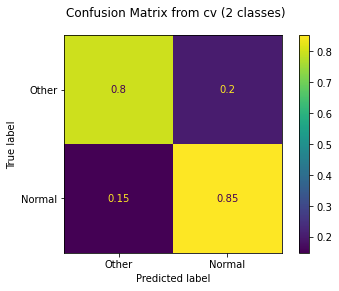

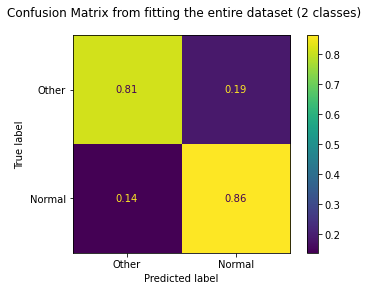

In [30]:
## -- compute CV performance metrics for 2 classes

# accuracy can be computed using cross_val_score on best_clf
# accuracy_cv = cross_val_score(best_clf2, X, y2, cv=skf)

# but mean/std can be extracted from result also by finding index for best_clf results
i_best = np.argmax(result2.cv_results_['mean_test_accuracy'])
mean_accuracy_cv = result2.cv_results_['mean_test_accuracy'][i_best]
std_accuracy_cv = result2.cv_results_['std_test_accuracy'][i_best]
mean_precision_cv = result2.cv_results_['mean_test_precision_macro'][i_best]
std_precision_cv = result2.cv_results_['std_test_precision_macro'][i_best]
mean_recall_cv = result2.cv_results_['mean_test_recall_macro'][i_best]
std_recall_cv = result2.cv_results_['std_test_recall_macro'][i_best]

# need to compute ypred for best_clf for confusion matrix results
y2pred_cv = cross_val_predict(best_clf2, X, y2, cv=skf)

## -- Evaluate model on the whole  dataset
y2pred = best_clf2.predict(X)
accuracy = accuracy_score(y2, y2pred)

print('Final best model performance (2 classes):')
print('\nMax Depth (max_depth)=%s, Number of Trees in the Forest (n_estimators)=%s ' 
      % (result2.best_params_['max_depth'],result2.best_params_['n_estimators']))

## Final model and its performance
#print('Accuracy from fitting the entire dataset=%.3f, Accuracy from CV=%.3f (%.3f)' 
#      % (accuracy, np.mean(accuracy_cv), np.std(accuracy_cv)))

print('\nEstimated accuracy (entire dataset)=%.3f, Average estimated Accuracy from CV=%.3f (%.3f)' % 
       (accuracy, mean_accuracy_cv, std_accuracy_cv))

print('\nPrecision CV=%.3f (%.3f), Recall CV=%.3f (%.3f)' 
      % (mean_precision_cv, std_precision_cv,
        mean_recall_cv, std_recall_cv))


disp = ConfusionMatrixDisplay.from_predictions(y2, y2pred_cv, normalize='true',
                                               labels=class2_names,display_labels=class2_names_str) 
disp.figure_.suptitle("Confusion Matrix from cv (2 classes)");

disp = ConfusionMatrixDisplay.from_predictions(y2, y2pred, normalize='true',
                                               labels=class2_names,display_labels=class2_names_str) 
disp.figure_.suptitle("Confusion Matrix from fitting the entire dataset (2 classes)");



The gridsearch found that Random Forest classifier using a max depth of 6 and 50 trees provides the best performance resulting in a slight improvement from our initial model (max depth of 4, 100 trees)  in all 3 metrics i.e. accuracy (from 0,81 to 0.83), precision (from 0.8 to 0.82) and Recall (from 0.81 to 0.83).

Let's visualize the results by plotting the decision regions and boundaries by projecting the high dimensional feaures space into 2 main components using tSNE (t-distributed stochastic neighbor embedding) dimensionality reduction techniques. 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.004s...
[t-SNE] Computed neighbors for 500 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.649543
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.396698
[t-SNE] KL divergence after 300 iterations: 0.339537


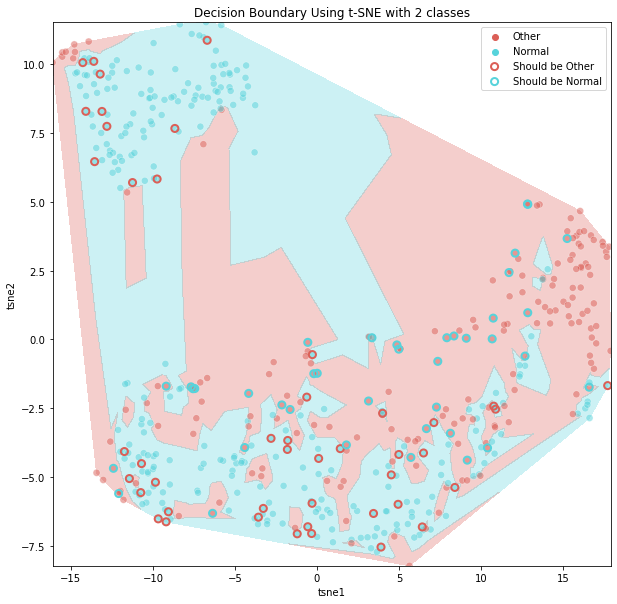

In [31]:
#from sklearn.inspection import DecisionBoundaryDisplay

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# define palettes 
palette = sns.color_palette("hls", 2)
hue_order = class2_names
my_cmap = ListedColormap(palette.as_hex())

# plot first decision boundary regions by assigning 0 for Other, 1 for Normal
y2pred_num = np.empty(np.size(y2pred))
for i,label in enumerate(class2_names):
    y2pred_num[y2pred==label]=i

##### TSNE projection to keep the top 2 components for 2D scatter plots
# create a random sample of size 500
isel = np.random.choice(len(X), 500, replace=False)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300);
X_tsne = tsne.fit_transform(X[isel])
df_tsne = pd.DataFrame(X_tsne,columns=["tsne1","tsne2"]) 

plt.figure(figsize=(10,10))

# plot first decision boundary regions
plt.tricontourf(X_tsne[:,0],X_tsne[:,1],y2pred_num[isel],levels=[0.5,1.5],lw=0.5,cmap =  my_cmap, alpha =0.3,extend="both")    

# then the predicted datapoints 
ax = sns.scatterplot(x="tsne1", y="tsne2",data=df_tsne,
                hue=y2pred[isel], palette=palette,hue_order=hue_order,
                legend="full", s=50, alpha=0.5)


# finally highlight incorrectly labeled data with an outer colored edge around the marker

for i,label in enumerate(class2_names): 
    plt.scatter(X_tsne[(y2pred[isel]!=y2[isel]) & (y2[isel]==label), 0], 
                X_tsne[(y2pred[isel]!=y2[isel]) & (y2[isel]==label), 1],
                s=50, facecolor = 'none', edgecolor=palette[i],marker="o",
                lw=2,label="Should be "+ class2_names_str[i])

handles, labels2  =  ax.get_legend_handles_labels()
ax.legend(handles, ['Other','Normal', 'Should be Other','Should be Normal'])
ax.set_title('Decision Boundary Using t-SNE with 2 classes');

### A Random Forest Model for 3 Classes  (Afib, Other and Normal)

Let's now try to check performance of our model when trying to predict the 3 classes: A for Atrial Fibrillation, O for other arrhythmia, and N for Normal (this took about 2 min on my 5yr laptop: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz)

Final best model performance for 3 classes:

Max Depth (max_depth)=6, Number of Trees in the Forest (n_estimators)=100 

Estimated accuracy (entire dataset)=0.780, Average estimated Accuracy from CV=0.764 (0.010)

Precision CV=0.698 (0.010), Recall CV=0.766 (0.015)
CPU times: total: 1min 45s
Wall time: 1min 47s


Text(0.5, 0.98, 'Confusion Matrix from fitting the entire dataset (3 classes)')

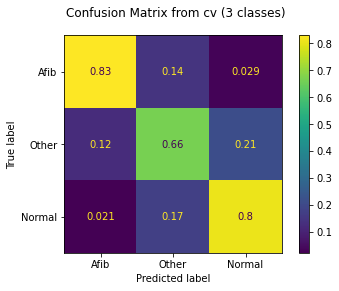

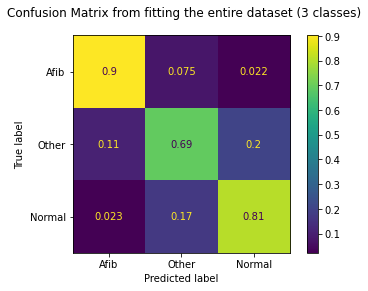

In [32]:
%%time
## --- execute search on 3 classes for comparison
class_names = np.array(['A','O','N'])
class_names_str = np.array(['Afib','Other','Normal'])

search = GridSearchCV(clf, grid, scoring=scoring, cv=skf, refit="accuracy")
result = search.fit(X, y)

# get the best performing model fit on the whole training set
best_clf = result.best_estimator_

## --- compute CV performance metrics for 2 classes

# but mean/std can be extracted from result also by finding index for best_clf results
i_best = np.argmax(result.cv_results_['mean_test_accuracy'])
mean_accuracy_cv = result.cv_results_['mean_test_accuracy'][i_best]
std_accuracy_cv = result.cv_results_['std_test_accuracy'][i_best]
mean_precision_cv = result.cv_results_['mean_test_precision_macro'][i_best]
std_precision_cv = result.cv_results_['std_test_precision_macro'][i_best]
mean_recall_cv = result.cv_results_['mean_test_recall_macro'][i_best]
std_recall_cv = result.cv_results_['std_test_recall_macro'][i_best]

# need to compute ypred for best_clf for confusion matrix results
ypred_cv = cross_val_predict(best_clf, X, y, cv=skf)

## -- Evaluate model on the whole  dataset
ypred = best_clf.predict(X)
accuracy = accuracy_score(y, ypred)

print('Final best model performance for 3 classes:')
print('\nMax Depth (max_depth)=%s, Number of Trees in the Forest (n_estimators)=%s ' 
      % (result.best_params_['max_depth'],result.best_params_['n_estimators']))

## Final model and its performance

print('\nEstimated accuracy (entire dataset)=%.3f, Average estimated Accuracy from CV=%.3f (%.3f)' % 
       (accuracy, mean_accuracy_cv, std_accuracy_cv))


print('\nPrecision CV=%.3f (%.3f), Recall CV=%.3f (%.3f)' 
      % (mean_precision_cv, std_precision_cv,
        mean_recall_cv, std_recall_cv))


disp = ConfusionMatrixDisplay.from_predictions(y, ypred_cv, normalize='true',
                                               labels=class_names,display_labels=class_names_str); 
disp.figure_.suptitle("Confusion Matrix from cv (3 classes)");

disp = ConfusionMatrixDisplay.from_predictions(y, ypred, normalize='true',
                                               labels=class_names,display_labels=class_names_str); 
disp.figure_.suptitle("Confusion Matrix from fitting the entire dataset (3 classes)");


The gridsearch found a Random Forest classifier using a max depth of 6 and 100 trees provides the best predictive accuracy for the 3 classes. 

Not surprisingly, the overall CV performance decreased down to 76% for accuracy, 70% for precision and 77% for recall. The model did a pretty good job in predicting Atrial Fibrillation (CV accuracy of 83%), but rather poorly for 'Other' arrhythmia which mainly was misclassified as normal in 2/3 of cases.

Let's visualize the results by plotting the decision regions using tSNE.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.003s...
[t-SNE] Computed neighbors for 500 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.826390
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.002209
[t-SNE] KL divergence after 300 iterations: 0.357181


Text(0.5, 1.0, 'Decision Boundary Using t-SNE with 3 classes')

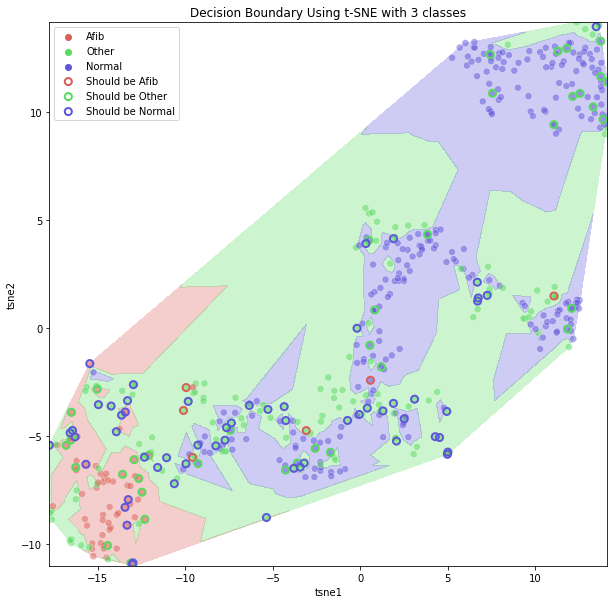

In [33]:
# define palettes 
palette = sns.color_palette("hls", 3)
hue_order = class_names
my_cmap = ListedColormap(palette.as_hex())

# plot first decision boundary regions by assigning 0 for Afib, 1 for Other and 2 for Normal
# Note that the use of tricontourf to draw regions separated by threshold boundary 0.5 and 1.5 
# is not quite accurate as it forces to create a Other/green (label =1) region between 
# Afib/red (level 0) and Normal/blue (level 2). To be fixed later... 
ypred_num = np.empty(np.size(ypred))
for i,label in enumerate(class_names):
    ypred_num[ypred==label]=i

##### TSNE projection to keep the top 2 components for 2D scatter plots
# create a random sample of size 500
isel = np.random.choice(len(X), 500, replace=False)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300);
X_tsne = tsne.fit_transform(X[isel])
df_tsne = pd.DataFrame(X_tsne,columns=["tsne1","tsne2"]) 

plt.figure(figsize=(10,10))

# plot first decision boundary regions
plt.tricontourf(X_tsne[:,0],X_tsne[:,1],ypred_num[isel],levels=[0.5,1.5],lw=0.5,cmap =  my_cmap, alpha =0.3,extend="both")    

# then the predicted datapoints 

ax = sns.scatterplot(x="tsne1", y="tsne2",data=df_tsne,
                hue=ypred[isel], palette=palette,hue_order=hue_order,
                legend="full", s=50, alpha=0.5)


# finally highlight incorrectly labeled data with an outer colored edge around the marker

for i,label in enumerate(class_names): 
    plt.scatter(X_tsne[(ypred[isel]!=y[isel]) & (y[isel]==label), 0], 
                X_tsne[(ypred[isel]!=y[isel]) & (y[isel]==label), 1],
                s=50, facecolor = 'none', edgecolor=palette[i],marker="o",
                lw=2,label="Should be "+ class_names_str[i])

handles, labels2  =  ax.get_legend_handles_labels()
ax.legend(handles, ['Afib','Other','Normal', 'Should be Afib','Should be Other','Should be Normal'])
ax.set_title('Decision Boundary Using t-SNE with 3 classes')

Clearly there is still a lot of overlap between `Other` and `Normal` rhythm classes, suggesting that the model may benefit from adding additional features.

# Improving our Classifier by Adding New Features

## Explore misclassified data

Let's explore our misclassified 'Other' data to get some ideas about additional features. The following script plots data for a couple of misclassified "other" cases. The code can be edited to explore more cases...

In [34]:
#%matplotlib auto # choose this option to explore more data by showing plots in a separate window 
%matplotlib inline  

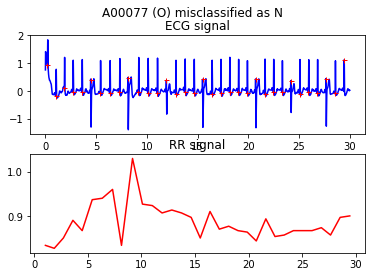

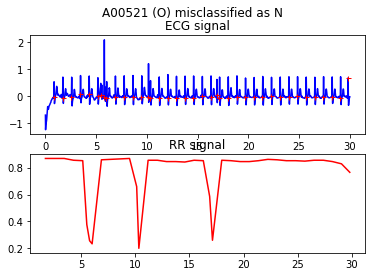

In [35]:
#fig = plt.figure(figsize=(12, 8))
#axs = fig.subplots(2)
#for i,yipred in enumerate(ypred): # to explore more of the data
for i in [67, 454]:
    #print(i)
    if (ypred[i]=='N') & (y[i]=='O') :
        #print('\r{}/{} ...'.format(i+1, SID[i]), end='')
        
        # get positive/negative Rpeaks indices
        fig = plt.figure()
        
        RR = np.diff(qrs[i])/fs
        ts = np.arange(len(ecgs[i]))/fs 
        #fig.clf()
        axs = fig.subplots(2)
        #axs[0].cla,axs[1].cla
        axs[0].plot(ts,ecgs[i],'b')
        axs[0].plot(ts[qrs[i]],ecgs[i][qrs[i]],'+r',ms=5)
                
        axs[0].set_title('ECG signal')
        axs[1].plot(ts[qrs[i]][1:],RR,'r')
        axs[1].set_title('RR signal')
        fig.suptitle('%s (%s) misclassified as %s' % (SID[i],y[i],ypred[i]))
        plt.show()
        # uncomment the following to explore more of the data
        #plt.pause(1)
        #while not plt.waitforbuttonpress(timeout=1):
        #    pass
    
    


In [36]:
%matplotlib inline

In essence, we see some abrupt changes in the RR data as well as the presence of negative peaks. We can try to create features to capture these observations. 

## Adding New Features

The following function finds the R-peak based on QRS indices and return indices of positive and negative R-peaks. The QRS indices provided actually correspond (mostly) to the timing of the beginning of QRS complex (Q event) and thus are a few samples prior to the R-peak. Once we find the indices of R-peaks, we determine whether they are  positive or negative peaks.

In [37]:
def indx_posnegRpeak(ecg,qrs_indx):
    # find the R peaks around the qrs_indices given by qrs_indx, 
    # and return indices of positive and negative peaks
    qrs_pos_indx, qrs_neg_indx =[],[]
    #print('new version 2')
    # note that range of indices around qrs index may need to be adjusted based on how qrs index is defined
    # here teh qrs indices correspond to the beginning of the QRS complex i.e. q timing
    # (occuring before the r-peak)
    for i,i_qrs in enumerate(qrs_indx):
        # define a local region around i_qrs that contains the R-peak
        i_aroundpeak = np.arange(max(0,i_qrs-10),min(len(ecg)-1,i_qrs+25))
        ecg_aroundpeak = ecg[i_aroundpeak]
        # find any minima and maxima using FindPeaks
        qrs_pos_local_indx = FindPeaks(ecg_aroundpeak, 10)
        qrs_neg_local_indx = FindPeaks(-ecg_aroundpeak, 10)
        #print(i,qrs_pos_local_indx)
        # make sure that local peak indices are for peaks not first/last index
        # check for postive peaks first
        if np.any(qrs_pos_local_indx != 0) & np.any(qrs_pos_local_indx != len(i_aroundpeak)-1):
            # if true peak, get local index of max peak (if there are several of them??) 
            # + index correction (i_aroundpeak[0]) to get global/entire signal index
            qrs_pos_local_indx = qrs_pos_local_indx[np.argmax(ecg_aroundpeak[qrs_pos_local_indx])]
        else:
            qrs_pos_local_indx = []
        # check for negative peaks
        if np.any(qrs_neg_local_indx != 0) & np.any(qrs_neg_local_indx != len(i_aroundpeak)-1):
            # if true peak, get local index of max peak (if there are several of them??) 
            qrs_neg_local_indx = qrs_neg_local_indx[np.argmax(ecg_aroundpeak[qrs_neg_local_indx])]
        else:
            qrs_neg_local_indx = []

        # check to make sure we have only one positive or negative peak (not both)
        # if not, keep the largest of the two as the true R-peak
        
        if (np.asarray(qrs_pos_local_indx).size) & (np.asarray(qrs_neg_local_indx).size):
            neg_peak_amp = (ecg_aroundpeak[max(0,qrs_neg_local_indx-5)] + 
                            ecg_aroundpeak[min(len(ecg)-1,qrs_neg_local_indx+5)] - 
                            2*ecg_aroundpeak[qrs_neg_local_indx]) 
            pos_peak_amp = (2*ecg_aroundpeak[qrs_pos_local_indx] -
                            ecg_aroundpeak[max(0,qrs_pos_local_indx-5)] -
                            ecg_aroundpeak[min(len(ecg)-1,qrs_pos_local_indx+5)])
            #print('Amplitude',neg_peak_amp,pos_peak_amp)
            if pos_peak_amp>=neg_peak_amp: # remove negative index
                qrs_neg_local_indx = []
            else:
                qrs_pos_local_indx = []
        #print('final',qrs_pos_local_indx)
        # append qrs_pos_indx/qrs_neg_indx if a positive/negative peak is found
        # must make a correction  by adding i_aroundpeak[0] to find absolute rather local index
        if qrs_pos_local_indx: 
            qrs_pos_indx.append(i_aroundpeak[0] + qrs_pos_local_indx)
            #print(qrs_pos_indx)
        if qrs_neg_local_indx: 
            qrs_neg_indx.append(i_aroundpeak[0] + qrs_neg_local_indx)
     
    return (qrs_pos_indx, qrs_neg_indx)   
            


Now that we have found the number of positive and negative peaks, let's update the featurize function to add new features. 

In [38]:
def Featurize_v2(ecg, qrs_inds, fs):
    """Featurize the qrs complex and its RR time series.

    Args:
        ecg: (np.array of number) the ecg raw signal
        qrs_inds: (np.array of number) the sample indices of the QRS complex locations
        fs: (number) the sampling rate

    Returns:
        n-tuple of features
    """
    # Compute the RR interval time series in s
    RR = np.diff(qrs_inds)/fs
    
    # Compute time domain features
    min_rr = np.min(RR)
    max_rr = np.max(RR)
    median_rr = np.median(RR)
    mean_rr = np.mean(RR)
    std_rr = np.std(RR)
    n_outliers = np.sum(RR>1.2*mean_rr)
    rmssd = np.sqrt(np.mean(np.square(np.diff(RR))))
    pdrr_50 = 100*np.mean(np.diff(RR)>0.05)

    
    ##### New features
    # get max/min change in RR intervals to capture extreme sudden change in RR intervals
    # this may complement n_outliers when this occurs a lot??
    min_rrdiff = np.min(np.diff(RR))
    max_rrdiff = np.max(np.diff(RR))   
    
    # Count the number of negative/positive Rpeaks
    (indx_posRPeak, indx_negRPeak) = indx_posnegRpeak(ecg,qrs_inds)
    n_posRpeaks = len(indx_posRPeak)
    n_negRpeaks = len(indx_negRPeak)
    # Count the number of negative/positive Rpeaks in %
    n_posRpeaks_perc = 100*len(indx_posRPeak)/(n_posRpeaks + n_negRpeaks)
    n_negRpeaks_perc = 100*len(indx_negRPeak)/(n_posRpeaks + n_negRpeaks)
    # total number of peaks to help capture noisy signals 
    n_Rpeaks = len(RR) 
    
    
    # Regularly resample the RR interval time series (done in terms of samples)
    fsi = 4 #resampling at 4Hz
    tsi = np.arange(qrs_inds[0]/fs, qrs_inds[-2]/fs, 1/fsi)
    RRi = np.interp(tsi,qrs_inds[:-1]/fs,RR)



    # Compute the Fourier transform of the regular RR interval time series
    freq = np.fft.rfftfreq(len(RRi), 1 / 4)
    fft_mag = np.abs(np.fft.rfft(RRi))

    # Compute frequency domain features
    ############# Didier
    # There was an error in the original solution
    # The size of the data within a certain freq band is smaller than the whole frequency data range
    # As such, the index pointing to the maximum of a freq band should be with respect to that freq band (not the whole range of freq)
    lf_mag = np.max(fft_mag[(freq >= 0.04) & (freq <= 0.15)])
    #lf_freq = freq[np.argmax(fft_mag[(freq >= 0.04) & (freq <= 0.15)])]  #<- error
    lf_freq = freq[(freq >= 0.04) & (freq <= 0.15)][np.argmax(fft_mag[(freq >= 0.04) & (freq <= 0.15)])]
    hf_mag = np.max(fft_mag[(freq >= 0.15) & (freq <= 0.4)])
    #hf_freq = freq[np.argmax(fft_mag[(freq >= 0.15) & (freq <= 0.4)])] #<- error
    hf_freq = freq[(freq >= 0.15) & (freq <= 0.4)][np.argmax(fft_mag[(freq >= 0.15) & (freq <= 0.4)])]

    #print(n_posRpeaks, n_negRpeaks, n_posRpeaks_perc, n_negRpeaks_perc, n_Rpeaks)
        
    return (min_rr, max_rr, median_rr, n_outliers, mean_rr, std_rr, rmssd, pdrr_50, 
            lf_mag, lf_freq, hf_mag, hf_freq,
            min_rrdiff, max_rrdiff, 
            n_posRpeaks, n_negRpeaks, n_posRpeaks_perc, n_negRpeaks_perc, n_Rpeaks)


The following code is used to check how well the negative/positive peaks are detected. It is set as "raw" format to be skipped. You can run this by converting the cell to code by pressing Esc+y 

In [39]:
%matplotlib inline

## Update the Feature Matrix

Let's update our feature vectors!

In [40]:
feats = [Featurize_v2(ecgs_k,qrs_k, fs) for ecgs_k,qrs_k in zip(ecgs,qrs)]      
X, y, y2 = np.array(feats), np.array(labels), np.array(labels2)
print(X.shape)


(7416, 19)


## Building a new Classifier with Updated Features using a Grid Search 

Following the same steps as we did previously, we implement a grid search with a stratified 5-fold cross-validation to find the best model.

In [41]:
%matplotlib inline

Final best model performance for 3 classes:

Max Depth (max_depth)=6, Number of Trees in the Forest (n_estimators)=150 

Estimated accuracy (entire dataset)=0.782, Average estimated Accuracy from CV=0.766 (0.012)

Precision CV=0.697 (0.013), Recall CV=0.767 (0.019)
CPU times: total: 2min 3s
Wall time: 2min 8s


Text(0.5, 0.98, 'Confusion Matrix from fitting the entire dataset (3 classes)')

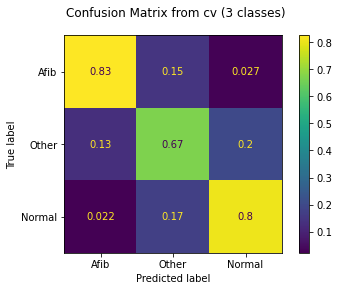

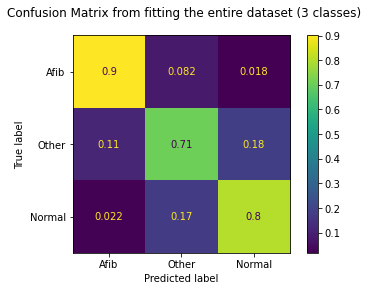

In [42]:
%%time
## --- execute search on 3 classes for comparison
class_names = np.array(['A','O','N'])
class_names_str = np.array(['Afib','Other','Normal'])

search = GridSearchCV(clf, grid, scoring=scoring, cv=skf, refit="accuracy")
result_v2 = search.fit(X, y)

# get the best performing model fit on the whole training set
best_clf_v2 = result_v2.best_estimator_

## --- compute CV performance metrics for 2 classes

# but mean/std can be extracted from result also by finding index for best_clf results
i_best = np.argmax(result_v2.cv_results_['mean_test_accuracy'])
mean_accuracy_cv = result_v2.cv_results_['mean_test_accuracy'][i_best]
std_accuracy_cv = result_v2.cv_results_['std_test_accuracy'][i_best]
mean_precision_cv = result_v2.cv_results_['mean_test_precision_macro'][i_best]
std_precision_cv = result_v2.cv_results_['std_test_precision_macro'][i_best]
mean_recall_cv = result_v2.cv_results_['mean_test_recall_macro'][i_best]
std_recall_cv = result_v2.cv_results_['std_test_recall_macro'][i_best]

# need to compute ypred for best_clf for confusion matrix results
ypred_cv = cross_val_predict(best_clf_v2, X, y, cv=skf)

## -- Evaluate model on the whole  dataset
ypred = best_clf_v2.predict(X)
accuracy = accuracy_score(y, ypred)

print('Final best model performance for 3 classes:')
print('\nMax Depth (max_depth)=%s, Number of Trees in the Forest (n_estimators)=%s ' 
      % (result_v2.best_params_['max_depth'],result_v2.best_params_['n_estimators']))

## Final model and its performance

print('\nEstimated accuracy (entire dataset)=%.3f, Average estimated Accuracy from CV=%.3f (%.3f)' % 
       (accuracy, mean_accuracy_cv, std_accuracy_cv))


print('\nPrecision CV=%.3f (%.3f), Recall CV=%.3f (%.3f)' 
      % (mean_precision_cv, std_precision_cv,
        mean_recall_cv, std_recall_cv))


disp = ConfusionMatrixDisplay.from_predictions(y, ypred_cv, normalize='true',
                                               labels=class_names,display_labels=class_names_str); 
disp.figure_.suptitle("Confusion Matrix from cv (3 classes)");

disp = ConfusionMatrixDisplay.from_predictions(y, ypred, normalize='true',
                                               labels=class_names,display_labels=class_names_str); 
disp.figure_.suptitle("Confusion Matrix from fitting the entire dataset (3 classes)");


The gridsearch found a Random Forest classifier using a max depth of 6 and 150 trees provides the best predictive accuracy for the 3 classes. 

Quite disappointingly, we observe no major improment in performance, which remains at 77% for accuracy, 70% for precision and 77% for recall. The model is still performing poorly in classifying 'Other' arrhythmia.

Let's look at which features are most contributing to the model performance

In [43]:
feature_names = ['min_rr', 'max_rr', 'median_rr', 'n_outliers', 'mean_rr', 'std_rr', 'rmssd', 'pdrr_50', 
                  'lf_mag', 'lf_freq', 'hf_mag', 'hf_freq',
                  'min_rrdiff', 'max_rrdiff', 
                  'n_posRpeaks', 'n_negRpeaks', 'n_posRpeaks_perc', 'n_negRpeaks_perc', 'n_Rpeaks']

feat_list_v2 = list(zip(feature_names, np.round(best_clf_v2.feature_importances_,3)))
feat_list = list(zip(feature_names, np.round(best_clf.feature_importances_,3)))
# create sorted list
feat_list_v2_sorted = sorted(feat_list_v2,key = lambda x:x[1],reverse=True)
feat_list_sorted = sorted(feat_list,key = lambda x:x[1],reverse=True)

# create DataFrames to display results 
df_v2 = pd.DataFrame(feat_list_v2_sorted,columns = ['Feature', 'Importances'],
                  index=range(1,len(feat_list_v2)+1))
df = pd.DataFrame(feat_list_sorted,columns = ['Feature', 'Importances'],
                  index=range(1,len(feat_list)+1))

# display DataFrames side by side
from IPython.display import display_html
df1_styler = df.style.set_table_attributes("style='display:inline'").set_caption('Original Model')
df2_styler = df_v2.style.set_table_attributes("style='display:inline'").set_caption('New Model with Added Features')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

,Feature,Importances
1,pdrr_50,0.272000
2,n_outliers,0.145000
3,rmssd,0.112000
4,median_rr,0.106000
5,min_rr,0.080000
6,std_rr,0.073000
7,mean_rr,0.072000
8,hf_mag,0.050000
9,max_rr,0.046000
10,lf_mag,0.026000


Given the lack of performance improvement, it is not surprising to see our positive/negative peak features at the bottom of the list. In contrast, max/min_rrdiff are within the top 10 features. 

Creating new features would require a little more effort. One idea would be to find the absence/presence and timing of the P- and T-wave (respectivtely the onset of atrial repolarization and end of the repolarization of the ventricules), as the T-wave is usually absent in Afib and T-wave abnormal/absent in other arrhythmias.   

# Comparing Different Classifiers

We have been so far only considering a Random Forest Classifier. Would other classifiers provide any improvement in performance?

In this section we will be performing a comprehensive comparison of different common classifiers, namely Nearest Neighbors, Decision Tree, Random Forest, Neural Net, AdaBoost, Naive Bayes, Quadratic Discriminant Analysis (QDA), Linear support vector machine (SVM), and RBF SVM.

This takes a while to run. Be patient.

In [257]:
import math
type(math.floor(2.1))
int(np.ceil(2.1))

3

In [255]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.inspection import DecisionBoundaryDisplay
import time

model_names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "Random Forest (Balanced)",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
#    "Linear SVM",
    "RBF SVM",
]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    RandomForestClassifier(class_weight = 'balanced'),
    MLPClassifier(max_iter=200),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
#    SVC(kernel="linear"),
    SVC(kernel='rbf'),
]

# defining the hyperparameters space
# C is a regularization parameters
# A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy.
# larger C increase computation time
Cs = [1, 10, 100, 1e3, 1e4] 
n_estimators = [2, 10, 20, 50, 100, 150, 300] # number of decision trees to be used in the forest
max_depth = np.array(range(1, 8)) #Set the max depth of the tree ; large number will result in overfitting noisy data
#class_weight = ["balanced",None] # balance classweights based on class sample

grid_KNeighbors = {'n_neighbors' : [1,2,4,8,16]}
grid_SVClinear = {"C": Cs} 
#gamma defines how much influence a single training example has; the larger gamma, the less distant examples are affected
grid_SVCrbf = {"gamma": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
               "C": Cs}
grid_DecisionTree= {'max_depth' : max_depth}
grid_RandomForest = {'n_estimators' : n_estimators,
                     'max_depth' : max_depth}
# For NN rules of thumbs: 1. size of hidden layers should be between input/output layers i.e. Number of features/class
#                         2. one layer works for most applications  
# For us this means between 20 to 3!
grid_MLP = {'hidden_layer_sizes': [(5,), (10,), (15,), (5,5), (10,10), (15,15), (5,5,5), (10,10,10), (15,15,15)],
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
grid_AdaBoost = {'n_estimators' : n_estimators}
grid_GaussianNB = {}
grid_QDA = {'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1),
            'store_covariance': (True, False),
            'tol': (0.0001, 0.001,0.01, 0.1)}

grid_hyperparam = [
    grid_KNeighbors ,
    grid_DecisionTree,
    grid_RandomForest,
    grid_RandomForest,
    grid_MLP,
    grid_AdaBoost,
    grid_GaussianNB,
    grid_QDA,
#    grid_SVClinear ,
    grid_SVCrbf ,
]

# Define Kfold and scoring
skf = StratifiedKFold(n_splits=5)
scoring = ['accuracy', 'precision_macro', 'recall_macro']

# Define table/list to save results/best model
result_table = []
ypred_cv_list = []
ypred_list = []
result_list = []

for name, clf, grid in zip(model_names, classifiers, grid_hyperparam):
    start_time = time.time()
    print("Running grid search for %s ..." % (name))
    clf_norm = clf #make_pipeline(StandardScaler(), clf)
    # define search
    search =  GridSearchCV(clf_norm, grid, scoring=scoring, cv=skf, refit="accuracy", verbose=2, return_train_score = True)
    # execute search on 2 classes
    result = search.fit(X, y)
    print("Search completed in %0.1f s" % (time.time() -start_time))
    # save CV results in a list for post analysis
    result_list.append(result)
        
    # get the best performing model fit on the whole training set
    best_clf = result.best_estimator_
        
    # need to compute ypred for best_clf for confusion matrix results
    ypred_cv = cross_val_predict(best_clf, X, y, cv=skf)
    ypred_cv_list.append(ypred_cv)
    
    ## -- Evaluate model on the whole  dataset
    ypred = best_clf.predict(X)
    ypred_list.append(ypred)
    
    accuracy = accuracy_score(y, ypred)    
          
    # save results for each model

    i_best = result.best_index_ #np.argmax(result.cv_results_['mean_test_accuracy'])
    mean_train_accuracy_cv = result.cv_results_['mean_train_accuracy'][i_best]
    std_train_accuracy_cv = result.cv_results_['std_train_accuracy'][i_best]
    mean_accuracy_cv = result.cv_results_['mean_test_accuracy'][i_best]
    std_accuracy_cv = result.cv_results_['std_test_accuracy'][i_best]
    mean_precision_cv = result.cv_results_['mean_test_precision_macro'][i_best]
    std_precision_cv = result.cv_results_['std_test_precision_macro'][i_best]
    mean_recall_cv = result.cv_results_['mean_test_recall_macro'][i_best]
    std_recall_cv = result.cv_results_['std_test_recall_macro'][i_best]
    
    # define a best clf string name with best_params values
    str1 = ", ";
    best_clf_name = name + ' (' + str1.join([i+':'+str(result.best_params_[i]) for i in result.best_params_]) + ')'

    result_table.append(
        (best_clf_name,    
         accuracy,
         str(np.round(mean_train_accuracy_cv,2)) + " (" + str(np.round(std_train_accuracy_cv,2)) + ")", 
         str(np.round(mean_accuracy_cv,2)) + " (" + str(np.round(std_accuracy_cv,2)) + ")", 
         str(np.round(mean_precision_cv,2)) + " (" + str(np.round(std_precision_cv,2)) + ")",
         str(np.round(mean_recall_cv,2)) + " (" + str(np.round(std_recall_cv,2)) + ")"    
         )
    )

    
    print('Best parameters', result.best_params_)
    print('Accuracy cv = %0.2f (%0.2f)\n' %(mean_accuracy_cv,std_accuracy_cv))      



          

Running grid search for Nearest Neighbors ...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ......................................n_neighbors=1; total time=   1.7s
[CV] END ......................................n_neighbors=1; total time=   0.5s
[CV] END ......................................n_neighbors=1; total time=   0.4s
[CV] END ......................................n_neighbors=1; total time=   0.4s
[CV] END ......................................n_neighbors=1; total time=   0.3s
[CV] END ......................................n_neighbors=2; total time=   0.3s
[CV] END ......................................n_neighbors=2; total time=   0.3s
[CV] END ......................................n_neighbors=2; total time=   0.4s
[CV] END ......................................n_neighbors=2; total time=   0.3s
[CV] END ......................................n_neighbors=2; total time=   0.3s
[CV] END ......................................n_neighbors=4; total time=   0.4s
[CV

Let's see the results

,Classifier,All dataset Acc,CV Acc,CV precision,CV Recall,CV Acc Afib,CV Acc Other,CV Acc Normal
0,Nearest Neighbors (n_neighbors:8),0.768474,0.71 (0.01),0.66 (0.03),0.64 (0.02),0.702400,0.297082,0.918746
1,Decision Tree (max_depth:7),0.835491,0.79 (0.01),0.75 (0.03),0.72 (0.02),0.643200,0.590186,0.909914
2,"Random Forest (max_depth:7, n_estimators:300)",0.855178,0.82 (0.01),0.81 (0.04),0.73 (0.02),0.608000,0.632184,0.936851
3,"Random Forest (Balanced) (max_depth:7, n_estimators:150)",0.808252,0.78 (0.01),0.72 (0.01),0.77 (0.02),0.806400,0.680813,0.821594
4,"Neural Net (alpha:0.01, hidden_layer_sizes:(15, 15))",0.753776,0.75 (0.01),0.71 (0.04),0.67 (0.02),0.662400,0.434571,0.903290
5,AdaBoost (n_estimators:150),0.809871,0.8 (0.01),0.75 (0.03),0.72 (0.02),0.643200,0.606985,0.910355
6,Naive Bayes (),0.687567,0.68 (0.01),0.59 (0.01),0.62 (0.02),0.676800,0.320955,0.867520
7,"QDA (reg_param:1e-05, store_covariance:True, tol:0.0001)",0.722762,0.71 (0.01),0.66 (0.03),0.66 (0.02),0.728000,0.356764,0.890704
8,"RBF SVM (C:10000.0, gamma:0.0001)",0.810545,0.78 (0.01),0.75 (0.02),0.71 (0.01),0.708800,0.482317,0.931331


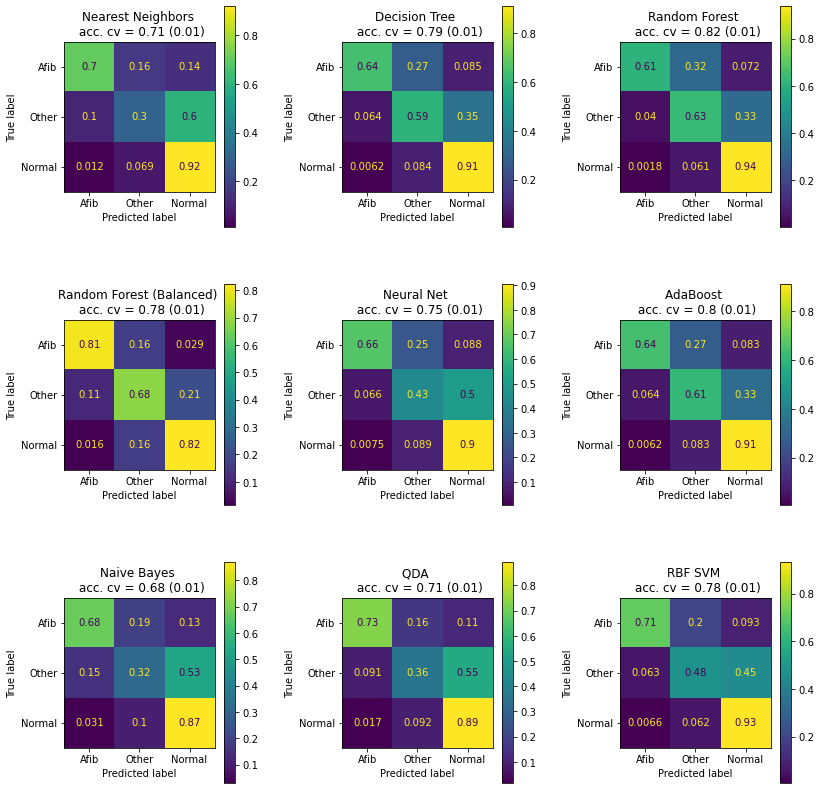

In [256]:
#print(pd.DataFrame([result.best_params_ for result in result_list]))
#print(result_list[2].best_params_)
#print(pd.DataFrame([str(i) for i in best_clf_list]))

# let's first compute accuracy results for each class
acc_class_table = []
for ypred_cv in ypred_cv_list:
    acc_list = []
    for class_val in class_names:
        acc_list.append(accuracy_score(y[y==class_val], ypred_cv[y==class_val])) 
    acc_class_table.append(acc_list)

df_acc_class = pd.DataFrame(acc_class_table, columns=['CV Acc Afib','CV Acc Other','CV Acc Normal'])  
    
df_results = pd.DataFrame(result_table, columns=['Classifier','All dataset Acc','CV Acc','CV precision', 'CV Recall']) 

df_all = pd.concat([df_results, df_acc_class], axis=1)
#df_styler = df.style.set_caption('New Model with Added Features')
display_html(df_all.style._repr_html_(), raw=True)

## ---- Ploting confusion matrix

# compute dimension of the subplot grids
Nclass = len(classifiers)+1
Nprow = int(np.floor(np.sqrt(Nclass)))
Npcol = int(np.ceil(Nclass/Nprow))
fig, axs = plt.subplots(Nc, Nr, figsize=(12, 12))

for i, name, ypred_cv in zip(range(len(model_names)),model_names, ypred_cv_list):
                   
    ir, ic = int(i / Nc) , i % Nc # computing subplot row/col indices
    cm = confusion_matrix(y, ypred_cv, normalize='true', labels=class_names) 
    disp = ConfusionMatrixDisplay(cm,display_labels=class_names_str).plot(ax=axs[ir,ic])
    axs[ir,ic].set_title("%s \n acc. cv = %s" %(name,result_table[i][2]));

    
fig.tight_layout(pad=3.0)

At the end of the day, the "non weighted" Random Forest Classifier is providing the best results. Now, you may wonder why do we get better results. It seems like the overall increase in accuracy comes to the cost of losing accuracy for 'Afib' while gaining accuracy in detecting 'Normal' rhythms. 

We have an unbalanced class with 625 records for 'Afib', 2262 for 'Other' and 4529 for 'Normal', in other words 'Afib' represents only 8.4% of the records. As the max depth increases, we are overfitting the data to the cost of reducing accuracy of detecting 'Afib'. Using a class-weighted classifier mitigates the unbalanced classes. We may not have as good as an overall accuracy but better results for 'Afib', which may provide a good compromise.

At the end, we need to decide what really matters (overall accuracy or better precision/recall for Afib, Other), so that we can rerun the classifer and grid search with a different scorer so as to tune our parameters to obtain our desired results.
